In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from scipy import stats

import precision_functions as prefun

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

### Constants

In [212]:
EVENT = "rastoc:stillness-position-lost"
TRIAL_TAG = "validation-stimulus"  # Opcion: "fixation-stimulus"  # Es el momento donde aparece la cruz de fijacion
FIRST_SAMPLE = 500
MAX_VAR = 75
MAX_PLOTS = None
VERBOSE = False
ALL_FILES_RAW = list(Path("./raw_data").glob("*.csv"))
LOAD_PATH = "./raw_data/juan_webcam9.csv"  # ·str(ALL_FILES_RAW[1])
LOAD_INFO = LOAD_PATH.split("/")[1].split("_")


# print("All files:",ALL_FILES_RAW, end='\n\n')
# print(f"""File loaded:
# {LOAD_INFO[0]}
# {LOAD_INFO[1]}
# {LOAD_INFO[2]}
# {LOAD_INFO[3]}
# {LOAD_INFO[4].split('.')[0]}""")


### Data load

In [213]:
print(LOAD_PATH)
df = pd.read_csv(LOAD_PATH)
df.head(5)

./raw_data/juan_webcam9.csv


,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,ip,user_agent,device,browser,browser_version,platform,platform_version,load_time,success,jspsych_start_time,item_width_mm,item_height_mm,item_width_px,px2mm,view_dist_mm,item_width_deg,px2deg,win_width_deg,win_height_deg,stimulus,response_type,key_press,avg_frame_time,center_x,center_y,rastoc-type,stimulus-coordinate,calibration-id,calibration-point-id,inner-width,inner-height,webgazer_data,webgazer_targets,session-id,validation-id,tracked-trial-id,trial-tag,start-x,start-y,events
0,195671.0,"{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",survey-html-form,0,195675,0.0-0.0,66,1,2023-01-31 17:57:42,242e4f7e01fe674438c476c7cfca5918,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,webgazer-init-camera,1,232060,0.0-1.0,66,1,2023-01-31 17:57:42,242e4f7e01fe674438c476c7cfca5918,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,fullscreen,2,236391,0.0-2.0,66,1,2023-01-31 17:57:42,242e4f7e01fe674438c476c7cfca5918,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,events-tracking-start,3,236392,0.0-3.0,66,1,2023-01-31 17:57:42,242e4f7e01fe674438c476c7cfca5918,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,2023-01-31T17:57:44.176Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,139754.0,NaN,virtual-chinrest,4,376148,0.0-4.0,66,1,2023-01-31 17:57:42,242e4f7e01fe674438c476c7cfca5918,157.92.27.254,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,WebKit,Chrome,107.0.0.0,Linux,NaN,NaN,NaN,NaN,85.6,53.98,346.0,4.04,609.33,8.035837,43.05712,44.591928,25.082959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check rastoc events

In [214]:
events  = prefun.get_rastoc_events(df, EVENT)
print("len(events):", len(events))

len(events): 63


### Precision experiment analysis

k: 0
k: 1
k: 2
k: 3
k: 4
k: 5
k: 6
k: 7
k: 8
k: 9
k: 10
k: 11
k: 12
k: 13
k: 14
k: 15
k: 16
k: 17
k: 18
k: 19
k: 20
k: 21
k: 22
k: 23
k: 24
k: 25
k: 26
k: 27
k: 28
k: 29
k: 30
k: 31
k: 32
k: 33
k: 34
k: 35
k: 36
k: 37
k: 38
k: 39
k: 40
k: 41
k: 42
k: 43
k: 44
k: 45
k: 46
k: 47
k: 48
k: 49
k: 50
k: 51
k: 52
k: 53
k: 54
k: 55
k: 56
k: 57
k: 58
k: 59
k: 60
k: 61
k: 62
k: 63
k: 64
k: 65
k: 66
k: 67
k: 68
k: 69
k: 70
k: 71
k: 72
k: 73
k: 74
k: 75
k: 76
k: 77
k: 78
k: 79
k: 80
k: 81
k: 82
k: 83
k: 84
k: 85
k: 86
k: 87
k: 88
k: 89
k: 90
k: 91
k: 92
k: 93
k: 94
k: 95
k: 96
k: 97
k: 98
k: 99
k: 100
k: 101
k: 102
k: 103
k: 104
k: 105
k: 106
k: 107
k: 108
k: 109
k: 110
k: 111
k: 112
k: 113
k: 114
k: 115
k: 116
k: 117
k: 118
k: 119
k: 120
k: 121
k: 122
k: 123
k: 124
k: 125
k: 126
k: 127
k: 128
k: 129
k: 130
k: 131
k: 132
k: 133
k: 134
k: 135
k: 136
k: 137
k: 138
k: 139
k: 140
k: 141
k: 142
k: 143
k: 144
k: 145
k: 146
k: 147
k: 148
k: 149
k: 150
k: 151
k: 152
k: 153
k: 154
k: 155
k: 156
k: 157
k: 1

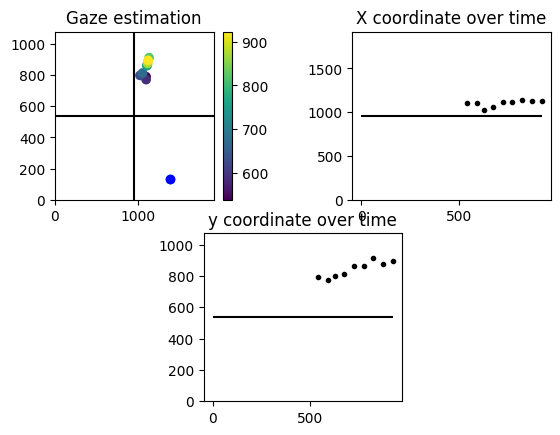

In [215]:
df_res = prefun.calculate_and_plot_errors(df, 
                                   TRIAL_TAG,
                                   first_sample=FIRST_SAMPLE,
                                   max_var=MAX_VAR,
                                   max_plots=MAX_PLOTS, 
                                   verbose=VERBOSE)

df_res.insert(0, 'abs', [i+1 for i in df_res.index])
i = 1
rounds = []
for num in range(1, 577):
    rounds.append(i)
    if num % 72 == 0:
        i = i + 1
df_res.insert(1, 'block', (df_res['trials']-1)%8 + 1)
df_res.insert(2, 'round', rounds)
df_res[['presented_point_x','presented_point_y']] = pd.DataFrame(df_res['presented_point'].tolist())
points_position_dict = dict(zip(df_res['presented_point'].unique(), range(1,10)))
df_res['target_id'] = df_res["presented_point"].map(points_position_dict)


print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")

In [275]:
points_position_dict = dict(zip(df_res['presented_point'].unique(), range(1,10)))

{(1391.0, 941.0): 1,
 (529.0, 536.0): 2,
 (1391.0, 536.0): 3,
 (960.0, 131.0): 4,
 (960.0, 536.0): 5,
 (529.0, 131.0): 6,
 (529.0, 941.0): 7,
 (960.0, 941.0): 8,
 (1391.0, 131.0): 9}

In [284]:
df_res.columns

Index(['abs', 'block', 'round', 'trials', 'first_sample', 'max_var',
       'presented_point', 'time_between_samples_mean',
       'time_between_samples_std', 'sampling_rate_mean', 'sampling_rate_std',
       'sampling_rate_min', 'sampling_rate_max', 'last_time_sample',
       'horizontal_errors_pxs', 'vertical_errors_pxs', 'total_errors_pxs',
       'horizontal_errors_pxs_mean', 'horizontal_errors_pxs_std',
       'vertical_errors_pxs_mean', 'vertical_errors_pxs_std',
       'total_errors_pxs_mean', 'total_errors_pxs_std', 'webgazer_x',
       'webgazer_y', 'webgazer_t', 'metadata', 'presented_point_x',
       'presented_point_y', 'target_id'],
      dtype='object')

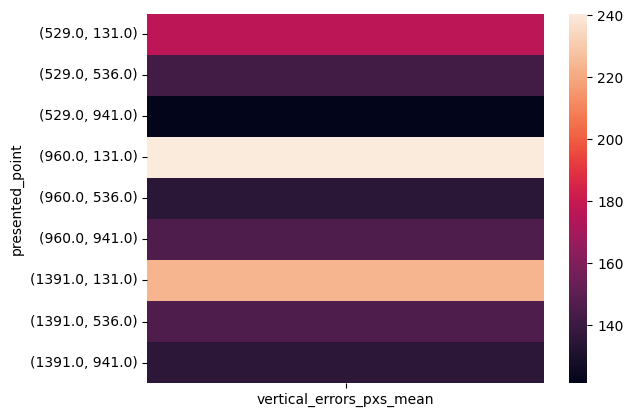

,vertical_errors_pxs_mean
presented_point,
"(529.0, 131.0)",176.712312
"(529.0, 536.0)",142.652156
"(529.0, 941.0)",121.377534
"(960.0, 131.0)",240.625260
"(960.0, 536.0)",134.859376
"(960.0, 941.0)",145.685564
"(1391.0, 131.0)",223.526752
"(1391.0, 536.0)",145.667318
"(1391.0, 941.0)",135.619962


In [308]:
df_presented_points = df_res.groupby('presented_point')['vertical_errors_pxs_mean'].mean()

df_presented_points = pd.DataFrame(df_presented_points)

sns.heatmap(df_presented_points)
plt.show()
df_presented_points

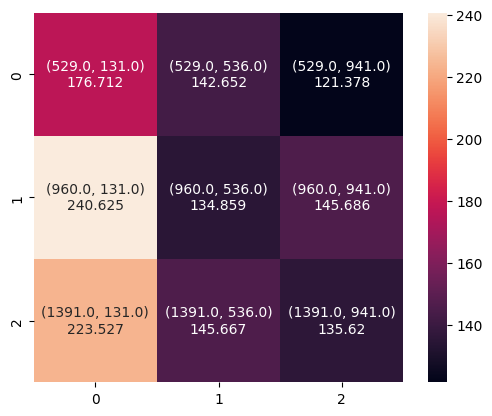

In [321]:
# vertical_errors_pxs_mean =
ax = sns.heatmap(
    df_res.groupby("presented_point")["vertical_errors_pxs_mean"]
    .mean()
    .values.reshape(3, 3),
    annot=True,
    square=True,
    cbar=True,
    fmt="g",
)


points = list(df_presented_points.index)
for i, t in enumerate(ax.texts):
    t.set_text(f"{points[i]}\n{t.get_text()}")


In [292]:
df_loco.index

Index([ (529.0, 131.0),  (529.0, 536.0),  (529.0, 941.0),  (960.0, 131.0),
        (960.0, 536.0),  (960.0, 941.0), (1391.0, 131.0), (1391.0, 536.0),
       (1391.0, 941.0)],
      dtype='object', name='presented_point')

In [276]:
df_res.head(6)

,abs,block,round,trials,first_sample,max_var,presented_point,time_between_samples_mean,time_between_samples_std,sampling_rate_mean,sampling_rate_std,sampling_rate_min,sampling_rate_max,last_time_sample,horizontal_errors_pxs,vertical_errors_pxs,total_errors_pxs,horizontal_errors_pxs_mean,horizontal_errors_pxs_std,vertical_errors_pxs_mean,vertical_errors_pxs_std,total_errors_pxs_mean,total_errors_pxs_std,webgazer_x,webgazer_y,webgazer_t,metadata,presented_point_x,presented_point_y,target_id
0,1,1.0,1,1.0,500,75,"(1391.0, 941.0)",53.529412,17.005596,20.778773,6.895259,11.904762,34.482759,910,"[87.0, 55.0, 53.0, 77.0, 31.0, 46.0, 55.0, 43....","[115.0, 122.0, 85.0, 137.0, 178.0, 61.0, 40.0,...","[144.20124826089406, 133.82451195502264, 100.1...",58.333333,17.454703,89.777778,48.654742,111.717918,40.667979,"[1110, 1098, 1067, 1054, 1124, 1146, 1405, 146...","[635, 603, 620, 600, 552, 570, 605, 743, 817, ...","[0, 84, 136, 212, 262, 313, 383, 417, 495, 547...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",1391.0,941.0,1
1,2,1.0,1,1.0,500,75,"(529.0, 536.0)",47.842105,10.974915,22.193325,5.851962,14.084507,34.482759,909,"[140.0, 241.0, 248.0, 189.0, 227.0, 249.0, 244...","[9.0, 13.0, 89.0, 19.0, 33.0, 17.0, 22.0, 57.0...","[140.28898745090436, 241.3503677229434, 263.48...",215.888889,34.948993,31.222222,24.389332,219.292814,36.190782,"[1466, 1424, 1462, 1414, 1413, 1399, 1368, 109...","[884, 898, 842, 891, 853, 697, 754, 754, 600, ...","[0, 66, 95, 145, 196, 247, 295, 347, 403, 451,...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",529.0,536.0,2
2,3,1.0,1,1.0,500,75,"(1391.0, 536.0)",52.647059,13.186183,20.376070,5.884580,12.987013,37.037037,895,"[211.0, 175.0, 145.0, 157.0, 154.0, 64.0, 78.0...","[21.0, 7.0, 85.0, 48.0, 47.0, 20.0, 84.0, 64.0]","[212.042448580467, 175.13994404475525, 168.077...",133.750000,48.733330,47.000000,27.631504,146.166084,43.266338,"[818, 717, 677, 709, 730, 784, 1149, 1465, 161...","[661, 662, 605, 566, 543, 565, 571, 523, 403, ...","[0, 66, 93, 145, 199, 244, 315, 364, 409, 468,...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",1391.0,536.0,3
3,4,1.0,1,1.0,500,75,"(960.0, 131.0)",45.600000,9.462558,23.002007,5.224297,16.393443,32.258065,912,"[282.0, 288.0, 243.0, 246.0, 230.0, 333.0, 315...","[205.0, 190.0, 117.0, 153.0, 149.0, 148.0, 210...","[348.6387815490411, 345.0275351330673, 269.699...",278.500000,31.449165,170.600000,28.852036,327.311430,36.814774,"[1384, 1391, 1496, 1500, 1560, 1479, 1347, 121...","[612, 582, 527, 418, 522, 350, 429, 432, 342, ...","[0, 61, 114, 164, 216, 262, 313, 363, 412, 443...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",960.0,131.0,4
4,5,1.0,1,1.0,500,75,"(960.0, 536.0)",40.409091,11.827007,26.447776,5.914175,14.492754,34.482759,889,"[200.0, 239.0, 186.0, 207.0, 274.0, 183.0, 158...","[141.0, 105.0, 12.0, 20.0, 103.0, 19.0, 23.0, ...","[244.70594598415462, 261.04788832702707, 186.3...",194.333333,39.645653,62.333333,44.402202,207.771024,45.004710,"[1215, 1290, 1216, 1241, 1244, 1221, 1274, 123...","[312, 247, 351, 325, 257, 246, 295, 385, 600, ...","[0, 67, 123, 157, 189, 222, 256, 289, 323, 355...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",960.0,536.0,5
5,6,1.0,1,1.0,500,75,"(529.0, 131.0)",48.526316,12.791315,22.031527,5.597295,13.333333,31.250000,922,"[173.0, 199.0, 196.0, 255.0, 293.0, 209.0, 297...","[43.0, 38.0, 40.0, 193.0, 111.0, 150.0, 40.0, ...","[178.2638493918495, 202.5956564193813, 200.039...",234.666667,41.087981,77.333333,55.801235,251.959185,48.656530,"[1078, 1152, 1220, 1124, 1258, 1187, 1047, 920...","[451, 455, 535, 481, 587, 508, 547, 501, 477, ...","[0, 71, 142, 196, 232, 266, 298, 333, 367, 419...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",529.0,131.0,6


In [8]:
df_res_ = df_res[['abs', 'block', 'round','target_id', 'horizontal_errors_pxs', 'vertical_errors_pxs', 'total_errors_pxs']]

In [65]:
df_res['horizontal_errors_pxs_mean_norm'] = df_res['horizontal_errors_pxs_mean'] / df_res['horizontal_errors_pxs_mean'].max()
df_res['vertical_errors_pxs_mean_norm'] = df_res['vertical_errors_pxs_mean'] / df_res['vertical_errors_pxs_mean'].max()

<Figure size 1500x800 with 0 Axes>

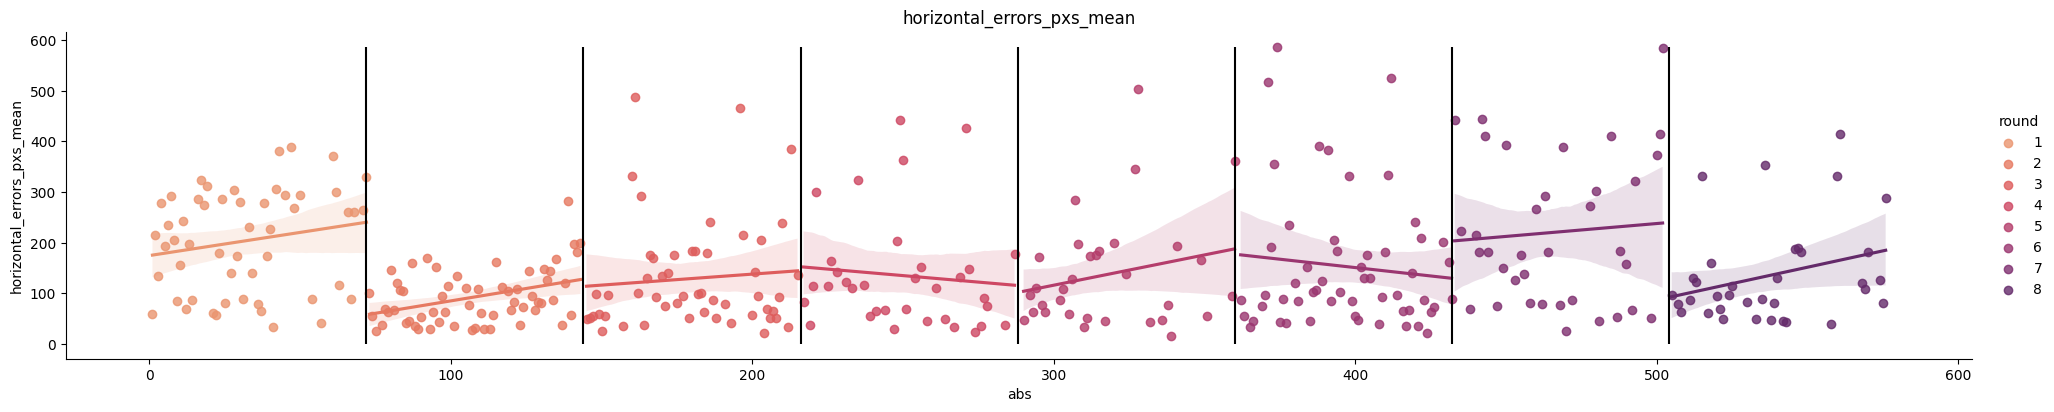

<Figure size 1500x800 with 0 Axes>

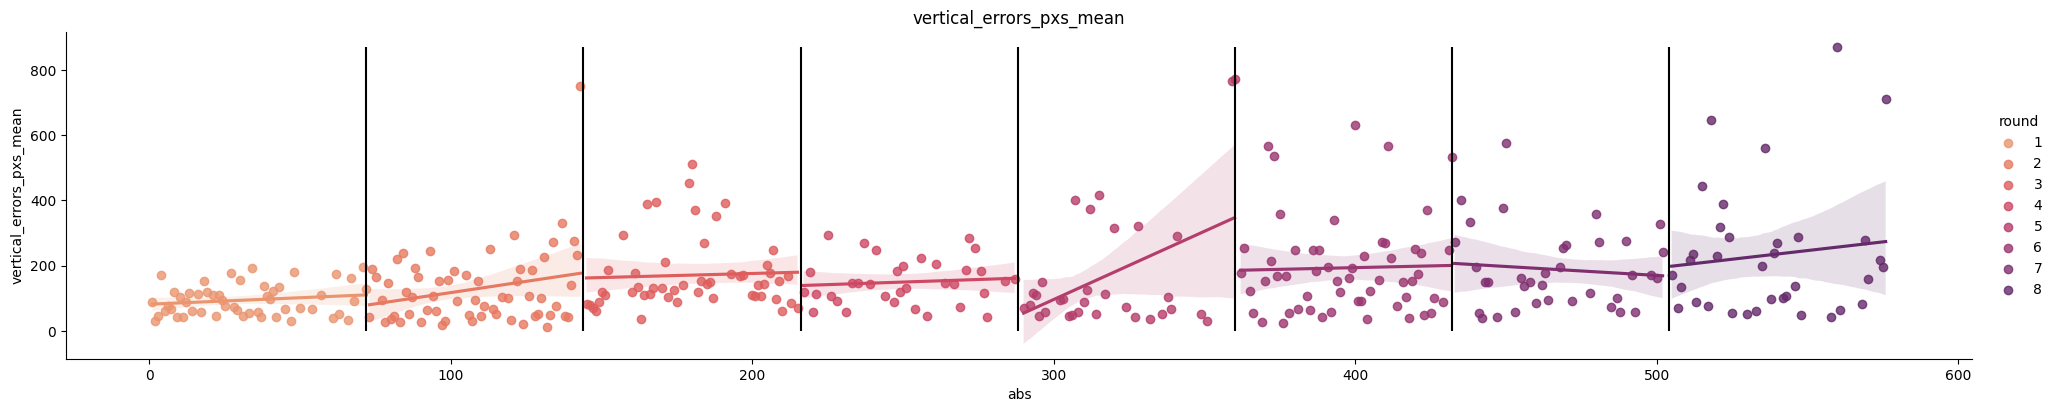

<Figure size 1500x800 with 0 Axes>

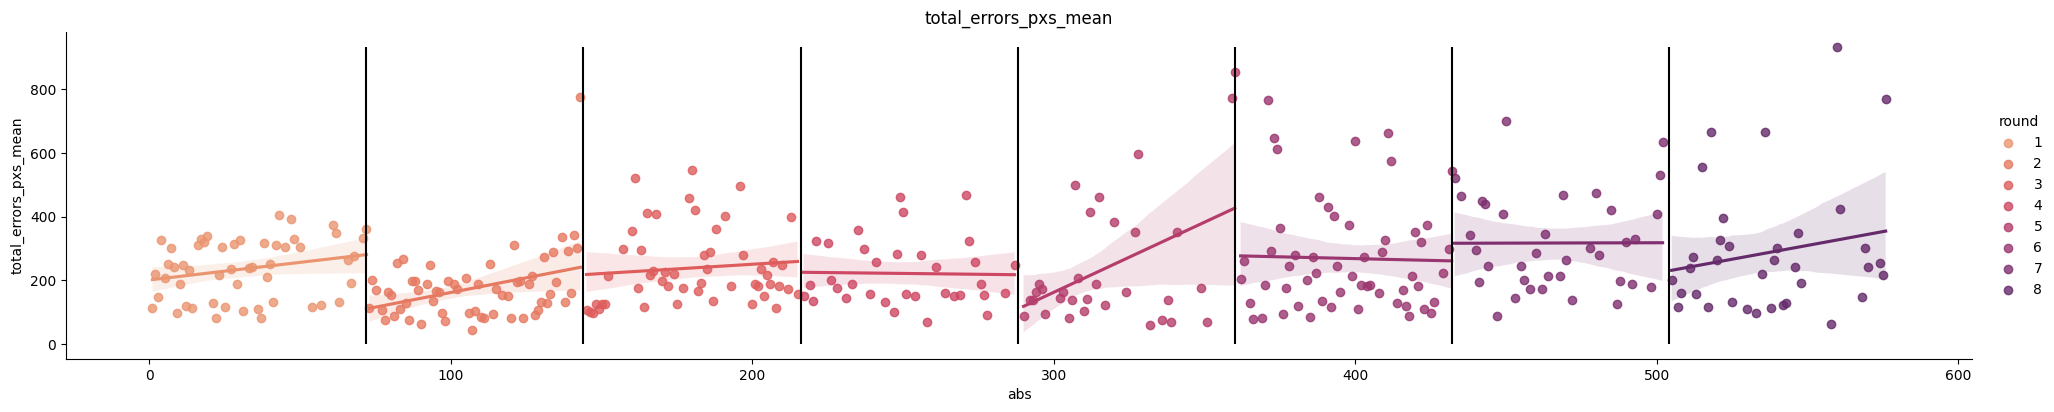

In [216]:
plt.figure(figsize=(15,8))
g = sns.lmplot(data=df_res, y='horizontal_errors_pxs_mean', x="abs", hue='round',height=4, aspect=5, palette='flare')
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=df_res['horizontal_errors_pxs_mean'].max(), colors='k')
plt.title('horizontal_errors_pxs_mean')
plt.show()

plt.figure(figsize=(15,8))
sns.lmplot(data=df_res, y='vertical_errors_pxs_mean', x="abs", hue='round',height=4, aspect=5, palette='flare')
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=df_res['vertical_errors_pxs_mean'].max(), colors='k')
plt.title('vertical_errors_pxs_mean')
plt.show()

plt.figure(figsize=(15,8))
sns.lmplot(data=df_res, y='total_errors_pxs_mean', x="abs", hue='round',height=4, aspect=5, palette='flare')
plt.vlines([i*72 for i in range(1,8)], ymin=0 , ymax=df_res['total_errors_pxs_mean'].max(), colors='k')
plt.title('total_errors_pxs_mean')
plt.show()

In [211]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_res['abs'],df_res['horizontal_errors_pxs_mean'])

slope


nan

In [171]:
df_res.columns

Index(['abs', 'block', 'round', 'trials', 'first_sample', 'max_var',
       'presented_point', 'time_between_samples_mean',
       'time_between_samples_std', 'sampling_rate_mean', 'sampling_rate_std',
       'sampling_rate_min', 'sampling_rate_max', 'last_time_sample',
       'horizontal_errors_pxs', 'vertical_errors_pxs', 'total_errors_pxs',
       'horizontal_errors_pxs_mean', 'horizontal_errors_pxs_std',
       'vertical_errors_pxs_mean', 'vertical_errors_pxs_std',
       'total_errors_pxs_mean', 'total_errors_pxs_std', 'webgazer_x',
       'webgazer_y', 'webgazer_t', 'metadata', 'presented_point_x',
       'presented_point_y', 'target_id'],
      dtype='object')

In [221]:
df_res.groupby('presented_point')

ans = [y for x, y in df_res.groupby('presented_point')]
len(ans)

9

In [269]:
X = df_res.groupby('presented_point').mean()['horizontal_errors_pxs_mean'].to_numpy() 



/tmp/ipykernel_38051/2686715590.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  X = df_res.groupby('presented_point').mean()['horizontal_errors_pxs_mean'].to_numpy()


(9,)

In [273]:
df_res.iloc[0:9]

,abs,block,round,trials,first_sample,max_var,presented_point,time_between_samples_mean,time_between_samples_std,sampling_rate_mean,sampling_rate_std,sampling_rate_min,sampling_rate_max,last_time_sample,horizontal_errors_pxs,vertical_errors_pxs,total_errors_pxs,horizontal_errors_pxs_mean,horizontal_errors_pxs_std,vertical_errors_pxs_mean,vertical_errors_pxs_std,total_errors_pxs_mean,total_errors_pxs_std,webgazer_x,webgazer_y,webgazer_t,metadata,presented_point_x,presented_point_y,target_id
0,1,1.0,1,1.0,500,75,"(1391.0, 941.0)",53.529412,17.005596,20.778773,6.895259,11.904762,34.482759,910,"[87.0, 55.0, 53.0, 77.0, 31.0, 46.0, 55.0, 43....","[115.0, 122.0, 85.0, 137.0, 178.0, 61.0, 40.0,...","[144.20124826089406, 133.82451195502264, 100.1...",58.333333,17.454703,89.777778,48.654742,111.717918,40.667979,"[1110, 1098, 1067, 1054, 1124, 1146, 1405, 146...","[635, 603, 620, 600, 552, 570, 605, 743, 817, ...","[0, 84, 136, 212, 262, 313, 383, 417, 495, 547...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",1391.0,941.0,1
1,2,1.0,1,1.0,500,75,"(529.0, 536.0)",47.842105,10.974915,22.193325,5.851962,14.084507,34.482759,909,"[140.0, 241.0, 248.0, 189.0, 227.0, 249.0, 244...","[9.0, 13.0, 89.0, 19.0, 33.0, 17.0, 22.0, 57.0...","[140.28898745090436, 241.3503677229434, 263.48...",215.888889,34.948993,31.222222,24.389332,219.292814,36.190782,"[1466, 1424, 1462, 1414, 1413, 1399, 1368, 109...","[884, 898, 842, 891, 853, 697, 754, 754, 600, ...","[0, 66, 95, 145, 196, 247, 295, 347, 403, 451,...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",529.0,536.0,2
2,3,1.0,1,1.0,500,75,"(1391.0, 536.0)",52.647059,13.186183,20.376070,5.884580,12.987013,37.037037,895,"[211.0, 175.0, 145.0, 157.0, 154.0, 64.0, 78.0...","[21.0, 7.0, 85.0, 48.0, 47.0, 20.0, 84.0, 64.0]","[212.042448580467, 175.13994404475525, 168.077...",133.750000,48.733330,47.000000,27.631504,146.166084,43.266338,"[818, 717, 677, 709, 730, 784, 1149, 1465, 161...","[661, 662, 605, 566, 543, 565, 571, 523, 403, ...","[0, 66, 93, 145, 199, 244, 315, 364, 409, 468,...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",1391.0,536.0,3
3,4,1.0,1,1.0,500,75,"(960.0, 131.0)",45.600000,9.462558,23.002007,5.224297,16.393443,32.258065,912,"[282.0, 288.0, 243.0, 246.0, 230.0, 333.0, 315...","[205.0, 190.0, 117.0, 153.0, 149.0, 148.0, 210...","[348.6387815490411, 345.0275351330673, 269.699...",278.500000,31.449165,170.600000,28.852036,327.311430,36.814774,"[1384, 1391, 1496, 1500, 1560, 1479, 1347, 121...","[612, 582, 527, 418, 522, 350, 429, 432, 342, ...","[0, 61, 114, 164, 216, 262, 313, 363, 412, 443...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",960.0,131.0,4
4,5,1.0,1,1.0,500,75,"(960.0, 536.0)",40.409091,11.827007,26.447776,5.914175,14.492754,34.482759,889,"[200.0, 239.0, 186.0, 207.0, 274.0, 183.0, 158...","[141.0, 105.0, 12.0, 20.0, 103.0, 19.0, 23.0, ...","[244.70594598415462, 261.04788832702707, 186.3...",194.333333,39.645653,62.333333,44.402202,207.771024,45.004710,"[1215, 1290, 1216, 1241, 1244, 1221, 1274, 123...","[312, 247, 351, 325, 257, 246, 295, 385, 600, ...","[0, 67, 123, 157, 189, 222, 256, 289, 323, 355...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",960.0,536.0,5
5,6,1.0,1,1.0,500,75,"(529.0, 131.0)",48.526316,12.791315,22.031527,5.597295,13.333333,31.250000,922,"[173.0, 199.0, 196.0, 255.0, 293.0, 209.0, 297...","[43.0, 38.0, 40.0, 193.0, 111.0, 150.0, 40.0, ...","[178.2638493918495, 202.5956564193813, 200.039...",234.666667,41.087981,77.333333,55.801235,251.959185,48.656530,"[1078, 1152, 1220, 1124, 1258, 1187, 1047, 920...","[451, 455, 535, 481, 587, 508, 547, 501, 477, ...","[0, 71, 142, 196, 232, 266, 298, 333, 367, 419...","{""name-id"":""Juan"",""webcam-id"":""9"",""computer-id...",529.0,131.0,6
6,7,1.0,1,1.0,500,75,"(529.0, 941.0)",47.000000,9.835489,22.592273,6.448156,16.129032,40.000000,893,"[331.0, 295.0, 295.0, 340.0, 299.0, 241.0, 308...","[29.0, 46.0, 69.0, 60.0, 28.0, 81.0, 118.0, 10...","

In [270]:
df_res.groupby('presented_point').mean()['horizontal_errors_pxs_mean']


/tmp/ipykernel_38051/1907884148.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_res.groupby('presented_point').mean()['horizontal_errors_pxs_mean']


presented_point
(529.0, 131.0)     137.472236
(529.0, 536.0)     193.823811
(529.0, 941.0)     181.204772
(960.0, 131.0)     124.945307
(960.0, 536.0)     112.214135
(960.0, 941.0)     136.448298
(1391.0, 131.0)    153.974895
(1391.0, 536.0)    157.610965
(1391.0, 941.0)    135.816907
Name: horizontal_errors_pxs_mean, dtype: float64

In [ ]:
# 8 rounds (calibracion)
    # 8 bloques ("trials"?)
        #  9 puntos

In [8]:
df_res['trials'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

### Analysis

In [18]:
print(f"Error: {df_res['total_errors_pxs_mean'].mean():.2f} +- {df_res['total_errors_pxs_mean'].std():.2f}")
print(f"Cantidad de NaNs: {df_res['total_errors_pxs_mean'].isna().sum()}")


Error: 153.29 +- 79.14
Cantidad de NaNs: 41


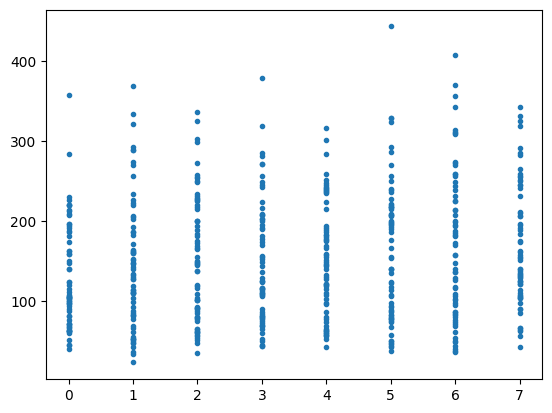

In [19]:
plt.plot((df_res['trials']-1)%8,df_res['total_errors_pxs_mean'],'.')

In [13]:
# plt.plot((df_res['trials']-1)%8,df_res['total_errors_pxs_mean'],'.')

# sns.regplot(df_res, x=(df_res['trials']-1)%8, y='total_errors_pxs_mean')

# a = (df_res['trials']-1)%8
# sns.boxplot(data=df_res, x=a, y='total_errors_pxs_mean')

In [14]:
# a = (df_res['trials']-1)%8
# # sns.regplot(df_res, x=a, y='total_errors_pxs_mean')
# ax = sns.scatterplot(df_res,  x=a, y='total_errors_pxs_mean', hue='presented_point')
# ax.legend(bbox_to_anchor=(1.3, 1.3))

In [15]:
center_x = df[df["trial-tag"] == TRIAL_TAG]["center_x"].iloc[0]
center_y = df[df["trial-tag"] == TRIAL_TAG]["center_y"].iloc[0]

df_res['presented_distance'] = df_res['presented_point'].apply(lambda x: np.sqrt((x[0] - center_x)**2 + (x[1] - center_y)**2))

df_res.groupby('presented_distance').mean()

/tmp/ipykernel_24392/2381804723.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_res.groupby('presented_distance').mean()


,abs,round,block,trials,first_sample,max_var,time_between_samples_mean,time_between_samples_std,sampling_rate_mean,sampling_rate_std,sampling_rate_min,sampling_rate_max,last_time_sample,horizontal_errors_pxs_mean,horizontal_errors_pxs_std,vertical_errors_pxs_mean,vertical_errors_pxs_std,total_errors_pxs_mean,total_errors_pxs_std,presented_point_x,presented_point_y
presented_distance,,,,,,,,,,,,,,,,,,,,,
0.00000,288.906250,4.5,4.406250,32.5,500.0,75.0,50.892808,14.958007,23.341257,13.469843,12.498773,66.124006,905.843750,121.993312,37.617953,136.613658,34.126576,199.059002,37.459120,960.0,536.0
379.00000,288.562500,4.5,4.437500,32.5,500.0,75.0,50.104262,15.048604,23.479062,12.699454,12.549191,62.492195,908.281250,79.708382,32.605055,110.542332,30.316950,149.518366,34.205467,960.0,536.0
535.98694,288.335938,4.5,4.585938,32.5,500.0,75.0,51.000629,15.209882,22.467002,9.989597,12.391536,49.644067,909.683594,68.343927,28.074207,112.318981,25.746991,146.176651,29.277942,960.0,536.0


In [ ]:
df_res[['presented_point_x','presented_point_y']] = pd.DataFrame(df_res['presented_point'].tolist())

In [ ]:
points_position_dict = dict(zip(df_res['presented_point'].unique(), range(1,10)))

df_res['presented_point_index'] = df_res["presented_point"].map(points_position_dict)

df_res.head(15)

In [ ]:
df_res[['presented_point_index', 'presented_point']].head(20)

In [ ]:
# plt.plot(df_res['trials'],df_res['total_errors_pxs_mean'],'.')
sns.regplot(df_res, x='trials', y='total_errors_pxs_mean')

In [218]:
ALL_FILES_ANALYZED = list(Path("./analyzed").glob("*.csv"))
ALL_FILES_ANALYZED

prefun.evaluate_experiment_instances(ALL_FILES_ANALYZED)

analyzed/analyzed_juan_repeticion_webcam9_computer3_chrome_ubuntu.csv
Error: 175.64 +- 112.13
Sampling rate: 23.30 +- 6.56
---
analyzed/analyzed_juan_webcam9.csv
Error: 243.31 +- 148.39
Sampling rate: 22.84 +- 7.42
---


In [ ]:
df_res['first_sample'].iloc[0]

### Save

In [217]:
SAVE_PATH = f"analyzed/analyzed_{LOAD_PATH.split('/')[-1]}"
print(f'Saved: {SAVE_PATH}')
df_res.to_csv(SAVE_PATH, index=False)

Saved: analyzed/analyzed_juan_webcam9.csv


### Cosas

In [ ]:

df = pd.read_csv('/home/gus/Downloads/antisacadas_91.csv')
df.head(5)

In [ ]:
df.columns

In [ ]:
# df[~df['webgazer_data'].isna()]['webgazer_data']

# Antisacadas
df_antisacadas = df.query("not webgazer_data.isnull() and typeOfSaccade == 'antisaccade'")

webgazer_data_antisacadas = df_antisacadas['webgazer_data'].map(eval)
for trial in range(len(df_antisacadas)):
    xs = [i['x'] for i in webgazer_data_antisacadas.iloc[trial]]
    ys = [i['y'] for i in webgazer_data_antisacadas.iloc[trial]]
    ts = [i['t'] for i in webgazer_data_antisacadas.iloc[trial]]
    plt.plot(ts, xs)

plt.title(f'antisacadas\nN={len(webgazer_data_antisacadas)}')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.show()

# Prosacadas
df_prosacadas = df.query("not webgazer_data.isnull() and typeOfSaccade == 'prosaccade'")

webgazer_data_prosacadas = df_prosacadas['webgazer_data'].map(eval)
for trial in range(len(df_antisacadas)):
    xs = [i['x'] for i in webgazer_data_prosacadas.iloc[trial]]
    ys = [i['y'] for i in webgazer_data_prosacadas.iloc[trial]]
    ts = [i['t'] for i in webgazer_data_prosacadas.iloc[trial]]
    plt.plot(ts, xs)

plt.title(f'Prosacadas\nN={len(webgazer_data_prosacadas)}')
plt.ylabel('x coordinate (pxs)')
plt.xlabel('time (ms)')
plt.show()

In [ ]:
trial = 100
xs = [i['x'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ys = [i['y'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]
ts = [i['t'] for i in df[~df['webgazer_data'].isna()]['webgazer_data'].map(eval).iloc[trial]]

plt.plot(ts, xs)
# plt.xlim(0, int(df[~df['webgazer_data'].isna()]['viewportWidth'].iloc[-1]))
# plt.ylim(0, df[~df['webgazer_data'].isna()]['viewportHeight'].iloc[-1])
# plt.colorbar()
plt.show()